In [3]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install pystan
!pip install nest_asyncio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, gamma, t # 1次元ガウス分布, ガンマ分布, 1次元スチューデントのt分布

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

Mounted at /content/drive


## 1次元ガウス分布の学習と予測：平均・精度が未知の場合
Stan 版です。

10.0


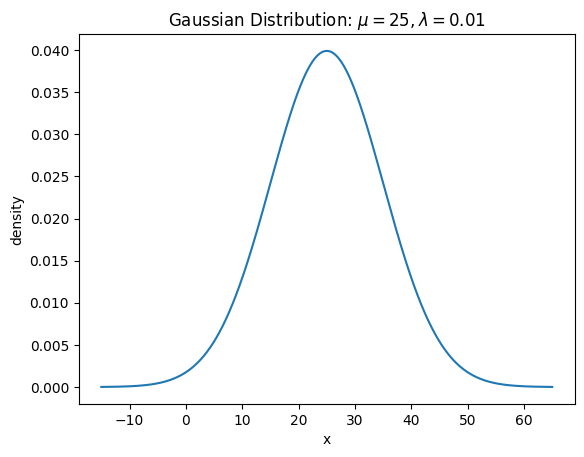

In [5]:
# 真のパラメータを指定
mu_truth = 25
lambda_truth = 0.01
print(np.sqrt(1 / lambda_truth)) # 標準偏差

# 作図用のxの値を設定
x_line = np.linspace(
    mu_truth - 4 * np.sqrt(1 / lambda_truth),
    mu_truth + 4 * np.sqrt(1 / lambda_truth),
    num=1000
)

# 尤度を計算:式(2.64)
# ln_C_N = - 0.5 *(np.log(2 * np.pi) - np.log(lambda_truth)) # 正規化項(対数)
# true_model = np.exp(ln_C_N - 0.5 * lambda_truth * (x_line - mu_truth)**2) # 確率密度
true_model = norm.pdf(x=x_line, loc=mu_truth, scale=np.sqrt(1 / lambda_truth)) # 確率密度 loc: 平均 (デフォルト:0), scale: 標準偏差 (デフォルト:1)

# 尤度を作図
plt.figure()
plt.plot(x_line, true_model) # 尤度
plt.xlabel('x')
plt.ylabel('density')
plt.title('Gaussian Distribution: $\mu=' + str(mu_truth) + ', \lambda=' + str(lambda_truth) + '$')
plt.show()

[21.02205734 27.7537923  21.48907289 25.89588437 26.95734314]


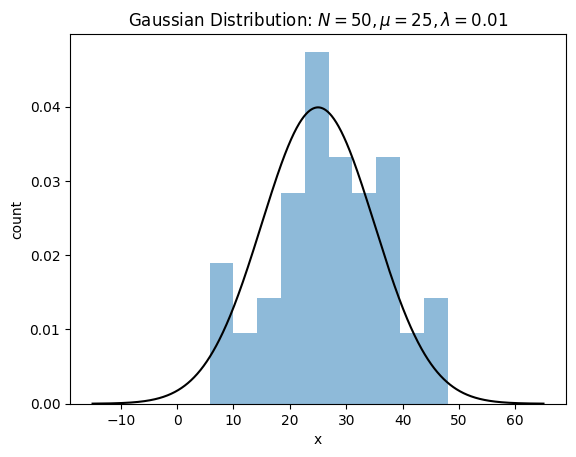

In [6]:
## 観測データの生成

# データ数を指定
N = 50

# ガウス分布に従うデータを生成
x_n = np.random.normal(loc=mu_truth, scale=np.sqrt(1 / lambda_truth), size=N)
print(x_n[:5]) # ndarray の先頭5個を表示

# 観測データのヒストグラムを作図
plt.figure()
plt.plot(x_line, true_model, color="black") # 尤度
plt.hist(x=x_n, density=True, alpha=0.5) # 観測データ
plt.xlabel('x')
plt.ylabel('count') # x軸目盛
plt.title('Gaussian Distribution: $N=' + str(N) + ', \mu=' + str(mu_truth) + ', \lambda=' + str(lambda_truth) + '$')
plt.show()

# ここまではいつものやつ

In [7]:
# Stan で扱えるよう辞書型の指定されたスタイルに変更する
data = pd.DataFrame(x_n, columns=["y"]) # ndarray を何かと便利な DataFrame に変換
stan_data = data.to_dict('list') # DataFrameを辞書型に変換 (この二段階変換はあまりかっこよくないですが)
stan_data.update({'N':len(x_n)}) # N の項目を追加
stan_data # 一番上に指定した columns 名 y が使われていることに注意

{'y': [21.022057342414385,
  27.753792303211974,
  21.489072887210995,
  25.89588436921538,
  26.957343143913132,
  12.177479498001755,
  29.003166630724483,
  23.37809520143316,
  5.781194019024966,
  24.86627338927862,
  38.48377248330632,
  21.387835442663587,
  38.56537515527177,
  17.242963536830818,
  27.821032915118536,
  9.907078909075828,
  33.876562368063915,
  40.73579751548695,
  16.859958505933015,
  38.15840656884596,
  35.559826003936806,
  24.02415494371974,
  25.514395770722466,
  28.37403114303202,
  33.23444415460652,
  6.133982958826255,
  9.054902368940107,
  20.439317582084705,
  14.47312508238589,
  25.94386608649961,
  12.839572490130589,
  23.181301009887644,
  26.49695857667553,
  35.83634652006849,
  20.410643832123572,
  24.867409461743883,
  33.34493855354014,
  23.997016291534294,
  47.98810056665282,
  42.10211471310562,
  33.584578157479804,
  36.07856558059876,
  22.39658299155036,
  32.596495156252985,
  44.48035015945082,
  44.769451135791535,
  31.04


Stan のコードの構成（model以外は省略可。ただし順番は守る必要あり）
*   functions{}:他のブロックで用いるユーザ定義の関数を記述する)
*   data{}:モデルに必要なデータやハイパーパラメータの型を宣言する
*   transformed data{}:データの中で宣言以外の処理をしたいものの宣言と処理を行う
*   parameters{}:サンプリングするパラメータの構造を宣言する
*   transformed parameters{}:パラメータの中で宣言以外の処理をするものの宣言と処理を行う
*   model{}:サンプリングしたい分布を記述する
*   generated quantities{}:各サンプリングで得たパラ毎に計算することができるブロック

データ型：
*   int:整数型
*   real:実数型 real<lower=0,upper=1>:カッコで制約を追加可能。例は最小値0、最大値1の実数
*   real a[N] : 変数aに実数の要素数がNの配列を宣言 vector[N]:N次元ベクトル(要素は実数)
*   simplex[N]:N次元ベクトルで総和が1
*   matrix[N,M]:N行M列の行列(要素は実数)
*   cov_matrix[M]:M行M列の分散共分散行列

分布の種類
normal
poisson

_rng:  ランダムサンプリング
_pdf: 確率密度関数
_lpdf: 対数確率密度関数
_pmf: 確率質量関数
_lpmf: 対数確率質量関数

generated quantities ブロックでは、モデルを推定するだけではいらないが、別の目的で乱数を得たいものを設定します。例えば、モデルを用いた予測値などはここに記述します。ここに記述すると、MCMCによるサンプリングの実行時間をほとんど犠牲にせずに、さまざまな乱数をえることができます。

normal_rng を使うことで、平均平均 mu, 標準偏差偏差 sigma の正規分布に従う乱数をを yhat に格納します。

In [8]:
stan_code = """
data { // 読み込む stan_data と項目名を一致させること
    int N; // サンプルサイズ
    vector[N] y; // データ
}
parameters {
    real mu; // 平均
    real<lower=0> sigma; // 標準偏差 <lower=0>は、0以上の値しか取らないという指定
}
model {
    // mu と sigma は分布を明示しない場合は、一様分布が仮定されるので、適切な事前分布を設定設定
    // し、結果を違いを確かめてみよう。以下より良い事前分布もあるので調べて設定してみてください。
    //mu ~ normal(0,100); 平均値の事前分布
    //sigma ~ cauchy(0,5); 標準偏差の事前分布
    for (i in 1:N) {
        y[i] ~ normal(mu, sigma); // 平均mu、標準偏差sigmaの正規分布。元がRなのでPythonと違い添字は1からはじまる
    }
    // y ~ normal(mu, sigma); // model では上の for 文は、左のように省略できる
}
"""

stan_code_v2 = """
data {
  int N; // サンプルサイズ
  vector[N] y; // データ
}
parameters {
  real mu; // 平均
  real<lower=0> sigma; // 標準偏差 <lower=0>は、0以上の値しか取らないという指定
}
model {
  for (i in 1:N) {
    y[i] ~ normal(mu, sigma);
  }
}
generated quantities {
  vector[N] yhat; // 事後予測分布
  for (i in 1:N) {
    yhat[i] = normal_rng(mu, sigma); // normal_rng: パラメータを指定した正規分布からランダムサンプリング
  }
}
"""

In [9]:
# 下のコードは stan_code しか使っていません。 適切な事前分布を設定しなおしたり、stan_code_v2 を試したり、分布を変えてみたりして、動作を確認してください。
model = stan.build(stan_code, data=stan_data, random_seed = 1) # テキスト情報からモデルの読み込み(コンパイル), 数分かかるかも

Building...



Building: 43.1s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [10]:
# MCMCの実行
fit = model.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples = 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 6.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     27.149  1.473  24.530   30.077      0.020    0.014    5451.0    4499.0   
sigma  10.361  1.103   8.448   12.481      0.015    0.011    5391.0    4515.0   

       r_hat  
mu       1.0  
sigma    1.0  


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,27.149,1.473,24.530,30.077,0.020,0.014,5451.0,4499.0,1.0
sigma,10.361,1.103,8.448,12.481,0.015,0.011,5391.0,4515.0,1.0


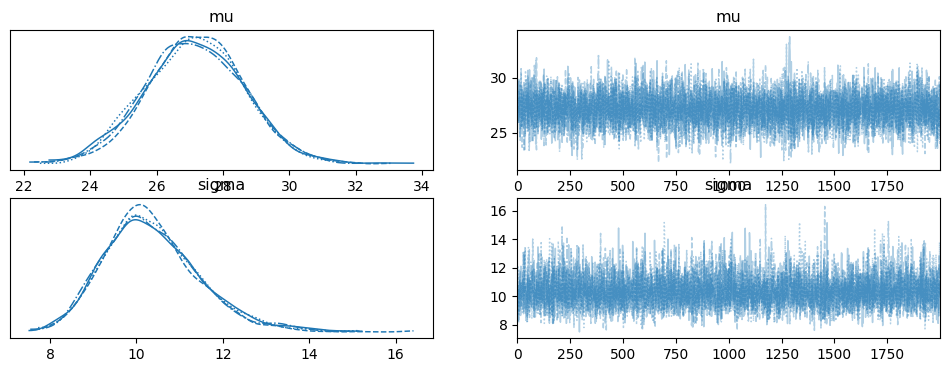

In [11]:
# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit)

#  Gelman-Rubin 統計量などの簡易表示
summary = arviz.summary(fit)
print (summary)

summary

In [12]:
result = fit.to_frame()

# 統計量の概要を確認
print(result.describe().T)

# 先頭を表示
result.head()

                count        mean       std         min         25%  \
parameters                                                            
lp__           8000.0 -138.873697  1.034925 -147.934586 -139.256114   
accept_stat__  8000.0    0.916028  0.113520    0.007026    0.883202   
stepsize__     8000.0    0.829622  0.088517    0.716300    0.763891   
treedepth__    8000.0    1.998625  0.614752    1.000000    2.000000   
n_leapfrog__   8000.0    3.839000  1.925498    1.000000    3.000000   
divergent__    8000.0    0.000000  0.000000    0.000000    0.000000   
energy__       8000.0  139.879992  1.447884  137.862275  138.827532   
mu             8000.0   27.148731  1.473102   22.153536   26.155283   
sigma          8000.0   10.360590  1.102808    7.509111    9.603080   

                      50%         75%         max  
parameters                                         
lp__          -138.560440 -138.132512 -137.843758  
accept_stat__    0.957223    0.994885    1.000000  
stepsize__

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma
draws,,,,,,,,,
0,-139.397357,1.000000,0.716300,3.0,7.0,0.0,140.639780,29.371218,9.513514
1,-139.115620,0.958645,0.874518,3.0,7.0,0.0,139.858352,25.354979,9.312123
2,-140.178305,0.842081,0.947914,2.0,3.0,0.0,140.838336,24.715333,9.117257
3,-137.957509,1.000000,0.779755,2.0,3.0,0.0,138.858822,27.553622,9.735773
4,-138.027410,0.959202,0.716300,3.0,7.0,0.0,140.321255,26.786099,9.574671


In [13]:
params = pd.DataFrame({'mu': result['mu'], 'sigma': result['sigma'], 'lp__': result['lp__']}) # DataFrame型に変換
params.to_csv(output_dir + "note3-2_output.csv")

10.360590360420657


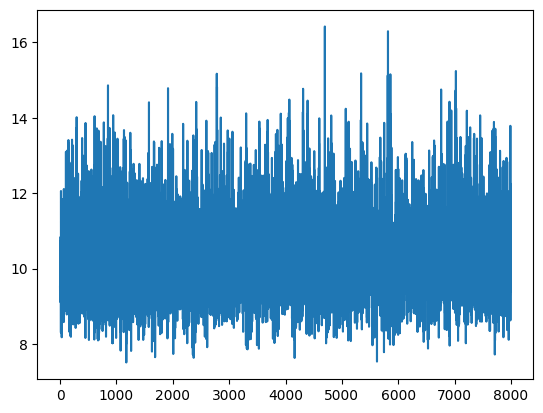

In [14]:
plt.plot(result["sigma"])
print (result['sigma'].mean())

(array([1.480e+02, 1.131e+03, 2.554e+03, 2.295e+03, 1.220e+03, 4.530e+02,
        1.480e+02, 3.800e+01, 1.100e+01, 2.000e+00]),
 array([ 7.50911079,  8.40062049,  9.29213019, 10.18363989, 11.07514959,
        11.96665929, 12.85816899, 13.74967869, 14.64118839, 15.53269809,
        16.42420779]),
 <BarContainer object of 10 artists>)

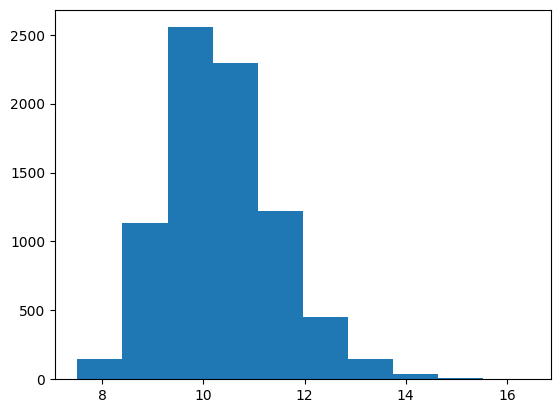

In [15]:
plt.hist(result["sigma"])